In [12]:
""" やること
1. LightGBMのトレーニング
2. モデルの精度検証
3. モデルを保存(pickle)
4. テストデータの予測を保存(csv)
"""
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [2]:
"""
各種設定
"""
pd.set_option('display.max_columns', 100)
PROJECT_FOLDER_PATH = "/Users/ritumutaka/J/Categorical_Feature_Encoding_Challenge_II"
RANDOM_STATE = 2020

In [3]:
"""
データ読み込み
train_X, train_y
test_X
"""
train = pd.read_csv(f"{PROJECT_FOLDER_PATH}/cat-in-the-dat-ii/output/train_tree.csv", index_col=0).sort_index(inplace=False)
train_X = train.drop(['target'], axis=1)
train_y = train['target']
test_X = pd.read_csv(f"{PROJECT_FOLDER_PATH}/cat-in-the-dat-ii/output/test_tree.csv", index_col=0).sort_index(inplace=False)
sample_submission = pd.read_csv(f"{PROJECT_FOLDER_PATH}/cat-in-the-dat-ii/input/sample_submission.csv", index_col=0)

# 不要な変数を削除
del train

In [4]:
"""
モデル定義
"""
TreeModel_LightGbm = lgb.LGBMClassifier(
    # デフォルトパラメータ
    random_state=RANDOM_STATE
)

In [5]:
"""
KFoldでvalidation
"""
kf = KFold(n_splits=5, shuffle=False, random_state=RANDOM_STATE)

EnsembleModels = []
RocScores = {}

for i, [tr_index, val_index] in tqdm(enumerate(kf.split(train_X, train_y))):
    TempModel_LightGbm = TreeModel_LightGbm.fit(train_X.iloc[tr_index, :], train_y.iloc[tr_index])
    EnsembleModels.extend([
        (f'LightGbm_{i}', TempModel_LightGbm),
    ])
    
    # validation
    RocScores[f'{i}'] = [
        roc_auc_score(train_y.iloc[val_index], TempModel_LightGbm.predict_proba(train_X.iloc[val_index, :])[:, 1]),
    ]

/Users/ritumutaka/.conda/envs/Categorical_Feature_Encoding_Challenge_II/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
5it [00:40,  8.12s/it]


In [6]:
"""
モデルを保存
"""
with open("./models/LightGBM_EnsembleModels.pickle", mode="wb") as f:
    pickle.dump(EnsembleModels, file=f)

"""
ローカルCV結果を保存
"""
with open("./models/LightGBM_RocScores.pickle", mode="wb") as f:
    pickle.dump(RocScores, file=f)

In [9]:
"""
テストテータの予測と保存
"""
EnsembleDf = sample_submission
for name_model in EnsembleModels:
    temp = pd.Series(data=name_model[1].predict_proba(test_X)[:, 1], index=test_X.index, name=name_model[0])
    EnsembleDf = pd.concat([EnsembleDf, temp], axis=1)

EnsembleDf.drop(['target'], axis=1, inplace=True)
EnsembleDf.sort_index(axis=1, inplace=True)   # カラム名でソート

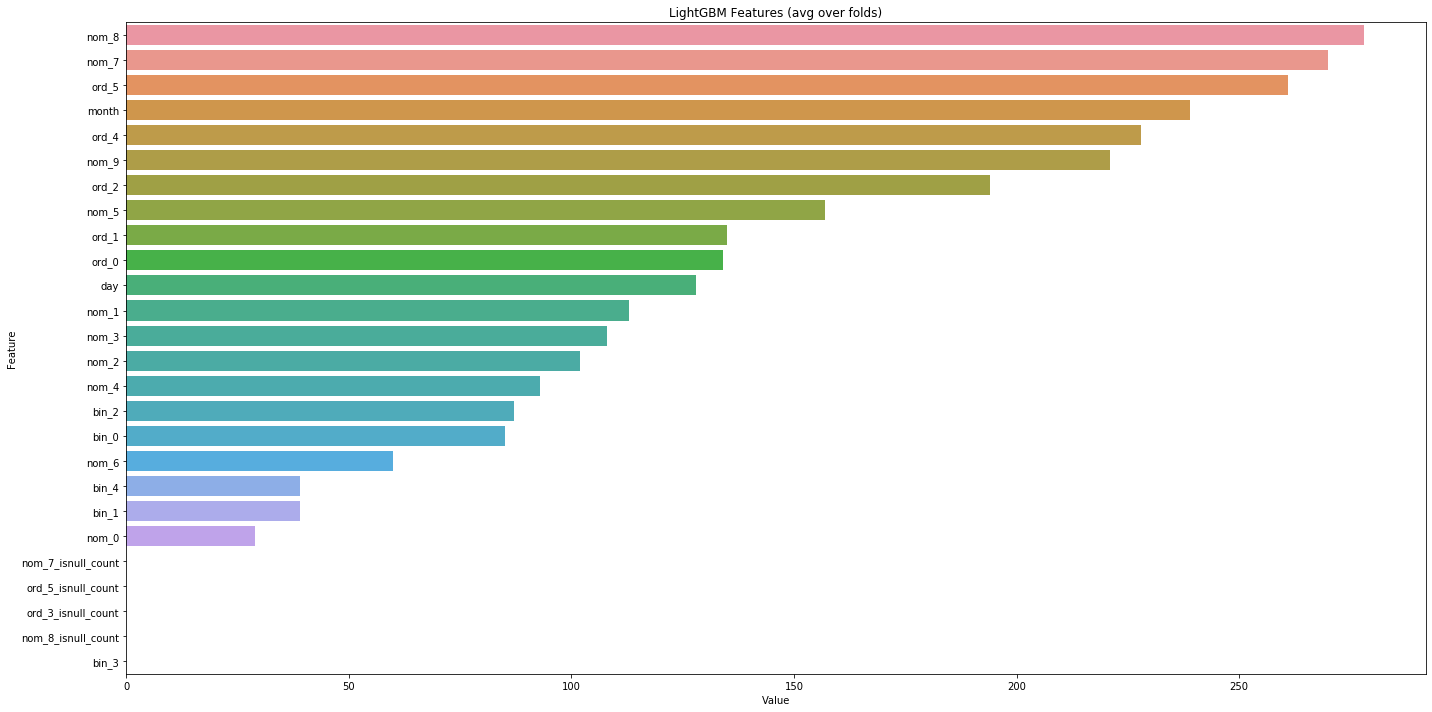

array([ 85,  39,  87,   0,  39,  29, 113, 102, 108,  93, 157,  60, 270,
       278, 221, 134, 135, 194, 228, 261, 128, 239,   0,   0,   0,   0],
      dtype=int32)

<Figure size 432x288 with 0 Axes>

In [13]:
feature_imp = pd.DataFrame(sorted(zip(EnsembleModels[0][1].feature_importances_,train_X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
